<a href="https://colab.research.google.com/github/khushee-g/EEG/blob/main/Muse_Raw_Data_to_Power_spectra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   Delta_TP9  Delta_AF7  Delta_AF8  Delta_TP10  Theta_TP9  Theta_AF7  \
0   1.034456   0.825003    1.38159    0.104863   0.969861   0.346395   
1   1.034456   0.825003    1.38159    0.104863   0.969861   0.346395   
2   1.034456   0.825003    1.38159    0.104863   0.969861   0.346395   
3   1.034456   0.825003    1.38159    0.104863   0.969861   0.346395   
4   1.034456   0.825003    1.38159    0.104863   0.969861   0.346395   

   Theta_AF8  Theta_TP10  Alpha_TP9  Alpha_AF7  ...  Beta_AF8  Beta_TP10  \
0   0.885847    0.710168   1.137895   0.598853  ...  0.170266   0.756086   
1   0.885847    0.710168   1.137895   0.598853  ...  0.170266   0.756086   
2   0.885847    0.710168   1.137895   0.598853  ...  0.170266   0.756086   
3   0.885847    0.710168   1.137895   0.598853  ...  0.170266   0.756086   
4   0.885847    0.710168   1.137895   0.598853  ...  0.170266   0.756086   

   Gamma_TP9  Gamma_AF7  Gamma_AF8  Gamma_TP10     RAW_TP9     RAW_AF7  \
0    0.35625   1.360112  -0.240145  

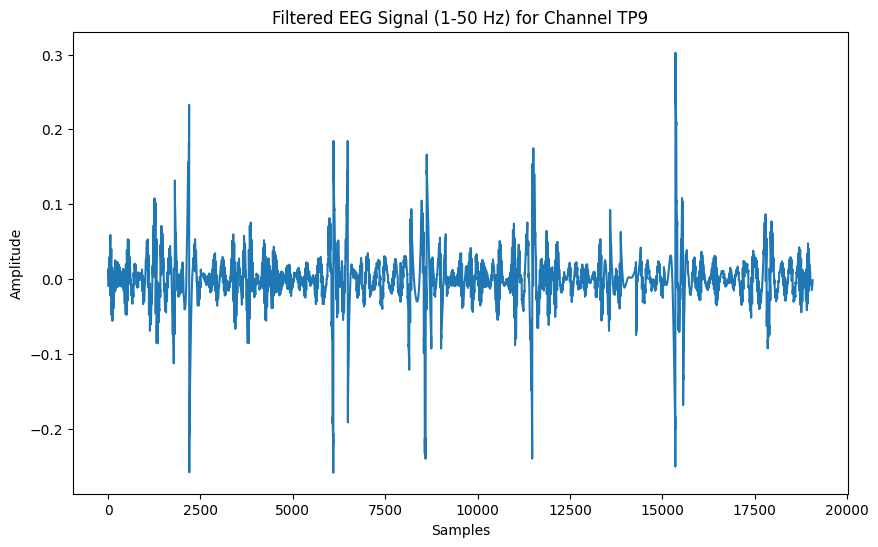

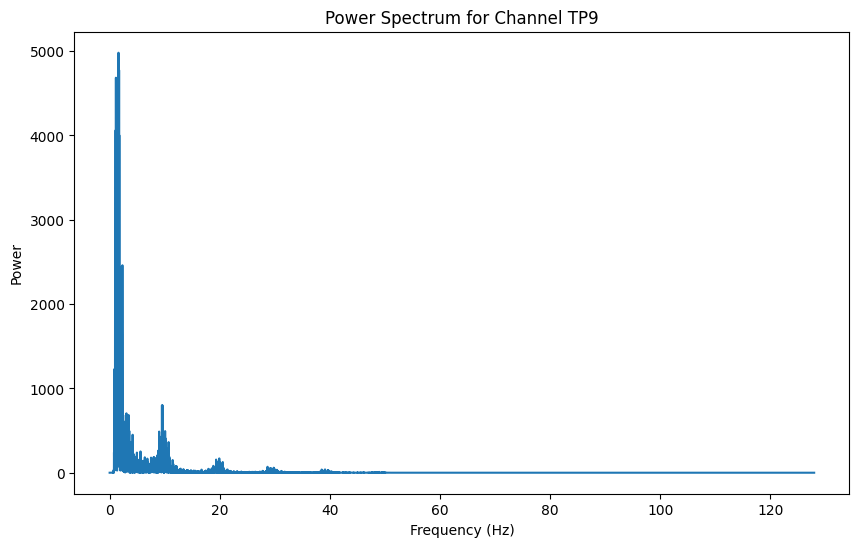

Power spectrum data saved to power_spectrum_data.csv
                   Delta         Theta         Alpha          Beta  \
Delta_TP9   1.370178e+05  1.512321e+04  1.965551e+04  1.015454e+04   
Delta_AF7   2.837631e+05  4.471869e+04  2.689852e+04  1.946405e+04   
Delta_AF8   1.539831e+05  1.019378e+04  3.037323e+04  1.426044e+04   
Delta_TP10  1.640929e+05  2.385050e+04  2.393234e+04  1.378659e+04   
Theta_TP9   1.405213e+05  2.390482e+04  1.725225e+04  1.154607e+04   
Theta_AF7   1.628998e+05  2.689402e+04  1.718573e+04  1.265706e+04   
Theta_AF8   7.125351e+04  4.381919e+03  1.459843e+04  6.388348e+03   
Theta_TP10  1.011769e+05  1.368826e+04  1.403124e+04  7.984912e+03   
Alpha_TP9   1.938488e+05  1.857978e+04  2.058602e+04  1.195375e+04   
Alpha_AF7   1.482550e+05  2.342875e+04  1.397413e+04  1.135876e+04   
Alpha_AF8   1.119832e+05  1.063913e+04  1.166450e+04  6.596021e+03   
Alpha_TP10  1.583053e+05  1.938046e+04  1.643997e+04  1.013774e+04   
Beta_TP9    1.091365e+04  6.683860e+0

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt

# 1. Load Raw EEG Data from CSV
df = pd.read_csv('/content/EEG Only mindMonitor_2024-11-15--21-52-00.csv')  # Adjust the file path as needed
print(df.head())  # Check first few rows of the data to inspect

# 2. Preprocess Data: Handle NaNs and apply Band-Pass Filter
# Check for NaN values and fill them with the channel's mean
def fill_nan_with_channel_mean(df):
    for column in df.columns:
        if df[column].isna().sum() > 0:  # Check if NaN values exist in the column
            mean_val = df[column].mean()
            df[column] = df[column].fillna(mean_val)
            print(f"Filled NaNs in channel '{column}' with the mean value: {mean_val}")
    return df

# Fill NaN values in the dataset
df = fill_nan_with_channel_mean(df)

# Band-pass filter function (1-50 Hz range) - Muse data often lies within this range
def bandpass_filter(data, lowcut=1, highcut=50, fs=256, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Apply band-pass filter to each EEG channel (1-50 Hz)
fs = 256  # Sampling rate of Muse device
filtered_df = df.apply(lambda x: bandpass_filter(x, lowcut=1, highcut=50, fs=fs))

# Plot a filtered signal for one channel (for inspection)
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['Delta_TP9'])
plt.title('Filtered EEG Signal (1-50 Hz) for Channel TP9')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

# 3. Compute Power Spectrum Using FFT
def compute_power_spectrum(data, fs):
    n = len(data)
    if n == 0 or np.all(data == 0):  # Handle empty or constant signals
        return np.nan, np.nan
    frequencies = fftfreq(n, 1/fs)
    fft_values = fft(data)  # Apply FFT to the signal

    # Compute the power spectrum (magnitude squared of the FFT)
    power_spectrum = np.abs(fft_values) ** 2

    # Only keep positive frequencies (ignore negative frequencies)
    positive_freqs = frequencies[:n//2]
    positive_power = power_spectrum[:n//2]

    return positive_freqs, positive_power

# 4. Create a DataFrame to Store Power Spectrum Data
power_spectrum_df = pd.DataFrame()

# Loop through each channel and compute its power spectrum
for channel in filtered_df.columns:
    eeg_data = filtered_df[channel].values

    # Ensure signal is not empty or constant
    if len(eeg_data) == 0 or np.all(eeg_data == 0):
        print(f"Warning: Channel {channel} has no data or constant signal!")
        power_spectrum_df[channel] = [np.nan] * (fs // 2)  # Assign NaN values for that channel
    else:
        freqs, power = compute_power_spectrum(eeg_data, fs)
        power_spectrum_df[channel] = power

# 5. Visualize the Power Spectrum for a Channel (Example: 'TP9')
plt.figure(figsize=(10, 6))
plt.plot(freqs, power_spectrum_df['Delta_TP9'])
plt.title('Power Spectrum for Channel TP9')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.show()

# 6. Save the Power Spectrum Data to a CSV File
power_spectrum_df.to_csv('power_spectrum_data.csv', index=False)
print('Power spectrum data saved to power_spectrum_data.csv')

# 7. (Optional) Extract Power in Specific Frequency Bands (e.g., Alpha, Beta)
# Define frequency bands (e.g., alpha: 8-13 Hz, beta: 13-30 Hz)
bands = {
    'Delta': (1, 4),    # 1-4 Hz
    'Theta': (4, 8),    # 4-8 Hz
    'Alpha': (8, 13),   # 8-13 Hz
    'Beta': (13, 30),   # 13-30 Hz
    'Gamma': (30, 50)   # 30-50 Hz
}

# Function to compute power in a given frequency band
def band_power(frequencies, power, low, high):
    band_idx = (frequencies >= low) & (frequencies <= high)
    return np.sum(power[band_idx])

band_power_df = pd.DataFrame(columns=bands.keys()) # Initialize with band names as columns

# Loop through each channel and compute the power in each band
for channel in filtered_df.columns:
    power_in_bands = []
    for band, (low, high) in bands.items():
        power_in_band = band_power(freqs, power_spectrum_df[channel], low, high)
        power_in_bands.append(power_in_band)

    # Store the band powers in the new DataFrame as a row
    band_power_df.loc[channel] = power_in_bands  # Use .loc to assign the row


# Rename the columns of the DataFrame to the band names
for channel in filtered_df.columns:
    power_in_bands = []
    for band, (low, high) in bands.items():
        power_in_band = band_power(freqs, power_spectrum_df[channel], low, high)
        power_in_bands.append(power_in_band)

    # Store the band powers in the new DataFrame as a row
    band_power_df.loc[channel] = power_in_bands  # Use .loc to assign the row

# Display the band power data (now channels are rows and bands are columns)
print(band_power_df)
# Display the band power data
print(band_power_df)

# 8. Save the Band Power Data (optional)
band_power_df.to_csv('band_power_data.csv', index=False)
print('Band power data saved to band_power_data.csv')
